## Recommender System

In this task, we will design and evaluate a movie recommendation system that predicts the ratings a user would give to a movie they have not yet rated. We will need to develop a recommendation system to predict the ratings in the test set.

In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
import networkx as nx
from sklearn.model_selection import train_test_split

### EDA

First, we import the csv's into dataframes.

In [86]:
df_rate = pd.read_csv("./train_data_movie_rate.csv")
df_trust = pd.read_csv("./train_data_movie_trust.csv")
df_test = pd.read_csv("./test_data.csv")

Then we do some analysis on the dataset in order to understand the data better.

In [87]:
df_rate.shape

(34298, 4)

In [88]:
df_trust.shape

(1853, 4)

In [89]:
df_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34298 entries, 0 to 34297
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       34298 non-null  int64  
 1   user_id  34298 non-null  int64  
 2   item_id  34298 non-null  int64  
 3   label    34298 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.0 MB


In [90]:
df_trust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               1853 non-null   int64
 1   user_id_trustor  1853 non-null   int64
 2   user_id_trustee  1853 non-null   int64
 3   trust_value      1853 non-null   int64
dtypes: int64(4)
memory usage: 58.0 KB


In [91]:
df_rate.describe()

,id,user_id,item_id,label
count,34298.000000,34298.000000,34298.000000,34298.000000
mean,17149.500000,764.002303,266.193452,3.006298
std,9901.124103,427.022738,349.849377,0.915706
min,1.000000,1.000000,1.000000,0.500000
25%,8575.250000,398.000000,12.000000,2.500000
50%,17149.500000,761.000000,216.000000,3.000000
75%,25723.750000,1142.000000,251.000000,4.000000
max,34298.000000,1508.000000,2071.000000,4.000000


In [92]:
df_trust.describe()

,id,user_id_trustor,user_id_trustee,trust_value
count,1853.000000,1853.000000,1853.000000,1853.0
mean,927.000000,775.437669,782.192121,1.0
std,535.059343,447.736536,471.614626,0.0
min,1.000000,2.000000,2.000000,1.0
25%,464.000000,410.000000,395.000000,1.0
50%,927.000000,752.000000,716.000000,1.0
75%,1390.000000,1160.000000,1187.000000,1.0
max,1853.000000,1641.000000,1642.000000,1.0


In [93]:
df_trust.head()

,id,user_id_trustor,user_id_trustee,trust_value
0,1,2,966,1
1,2,2,104,1
2,3,5,1509,1
3,4,6,1192,1
4,5,7,1510,1


In [94]:
df_rate.head()

,id,user_id,item_id,label
0,1,1,1,2.0
1,2,1,2,4.0
2,3,1,3,3.5
3,4,1,4,3.0
4,5,1,5,4.0


In [95]:
df_rate.dtypes

id           int64
user_id      int64
item_id      int64
label      float64
dtype: object

In [96]:
df_trust.dtypes

id                 int64
user_id_trustor    int64
user_id_trustee    int64
trust_value        int64
dtype: object

In [97]:
missing_data_rate = df_rate.isnull()
for column in missing_data_rate.columns.values.tolist():
    print(column)
    print (missing_data_rate[column].value_counts())
    print("")    

id
id
False    34298
Name: count, dtype: int64

user_id
user_id
False    34298
Name: count, dtype: int64

item_id
item_id
False    34298
Name: count, dtype: int64

label
label
False    34298
Name: count, dtype: int64



In [98]:
missing_data_trust = df_trust.isnull()
for column in missing_data_trust.columns.values.tolist():
    print(column)
    print (missing_data_trust[column].value_counts())
    print("")    

id
id
False    1853
Name: count, dtype: int64

user_id_trustor
user_id_trustor
False    1853
Name: count, dtype: int64

user_id_trustee
user_id_trustee
False    1853
Name: count, dtype: int64

trust_value
trust_value
False    1853
Name: count, dtype: int64



As we can see, there is no null value in any of the dataframes so there is no need to handle any missing values.

In [99]:
df_trust["trust_value"].value_counts()

trust_value
1    1853
Name: count, dtype: int64

All the trust values are 1 in the trust dataframe.

Now we will do some visualization to get better insight of the data.

Below iis the Rating-Frequency plot that shows the frequency of different ranges of ratings as histogram:

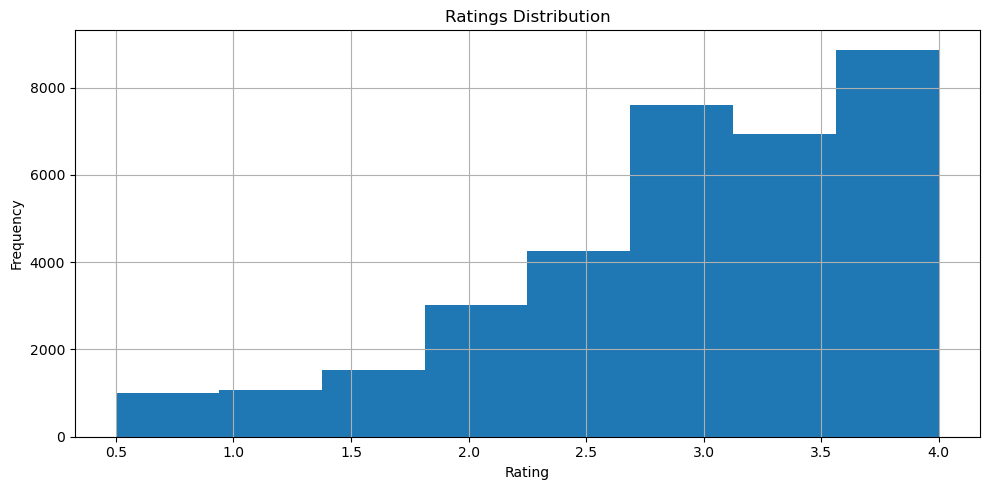

In [100]:
plt.figure(figsize=(10,5))
df_rate["label"].hist(bins=8)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Below plot shows the number of ratings per user:

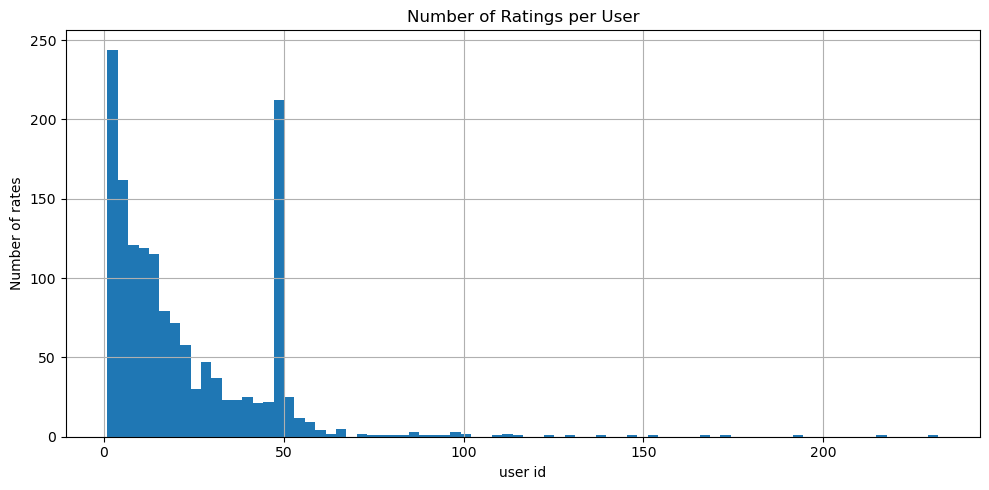

In [101]:
plt.figure(figsize=(10,5))
df_rate.groupby("user_id").size().hist(bins=80)
plt.title("Number of Ratings per User")
plt.xlabel("user id")
plt.ylabel("Number of rates")
plt.tight_layout()
plt.show()

Below is the number of submitted ratings per movie:

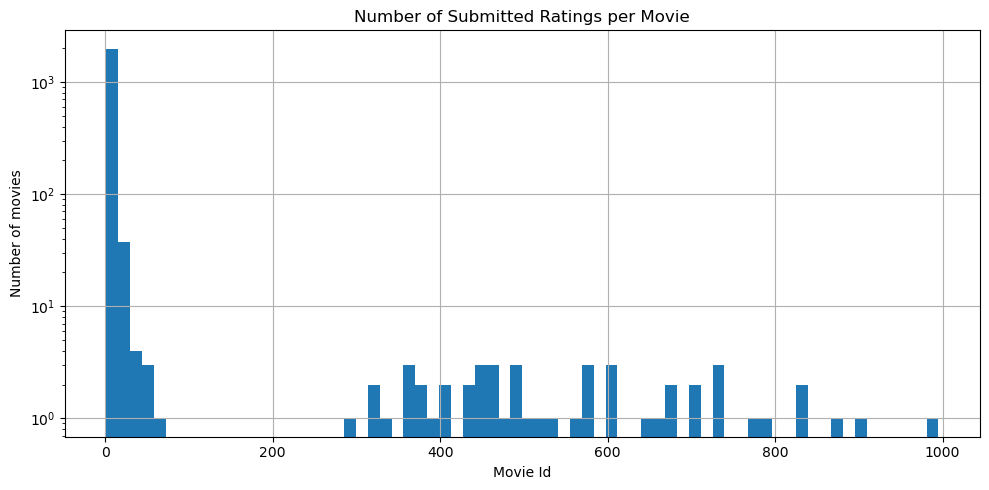

In [102]:
plt.figure(figsize=(10,5))
df_rate.groupby("item_id").size().hist(bins=70)
plt.title("Number of Submitted Ratings per Movie")
plt.xlabel("Movie Id")
plt.ylabel("Number of movies")
plt.yscale("log")
plt.tight_layout()
plt.show()

For the final plot, below is the number of trustees pre trustor:

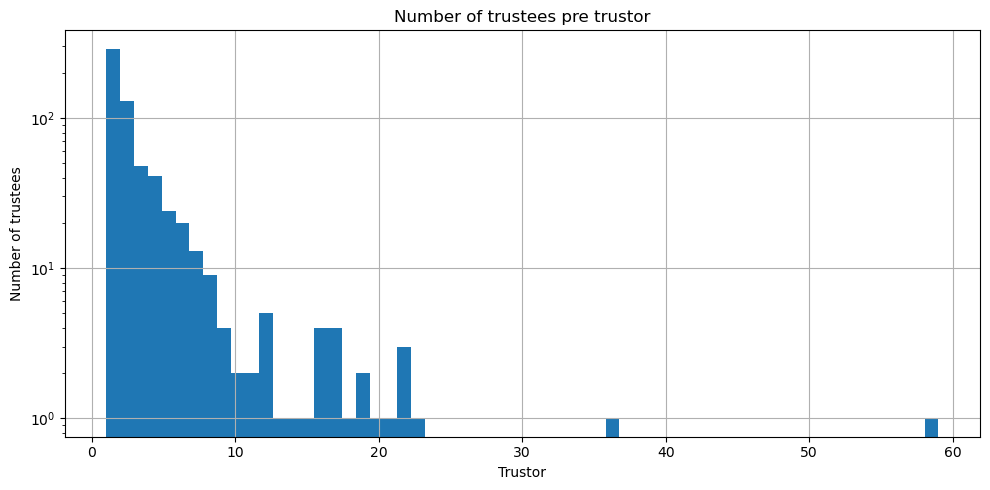

In [103]:
plt.figure(figsize=(10,5))
df_trust.groupby("user_id_trustor").size().hist(bins=60)
plt.title("Number of trustees pre trustor")
plt.xlabel("Trustor")
plt.ylabel("Number of trustees")
plt.yscale("log")
plt.tight_layout()
plt.show()

Also we will plot the correlation plot. By examining the correlation plot, we can identify which features are highly correlated with each other. This information can guide feature selection, preprocessing, and fianl model for our task.

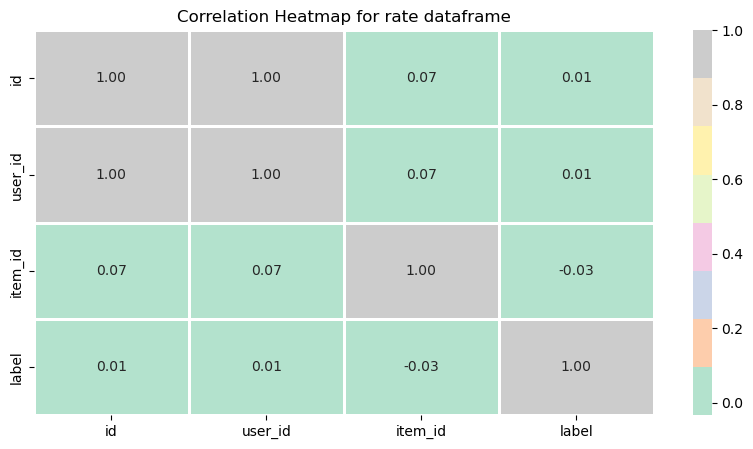

In [104]:
plt.figure(figsize=(10, 5))

sns.heatmap(df_rate.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)
 
plt.title('Correlation Heatmap for rate dataframe')
plt.show()

### Data Preprocessing and Feature Engineering

First, we drop the duplicate values from the datasets:

In [105]:
df_rate = df_rate.drop_duplicates(subset=['user_id', 'item_id'])
df_trust = df_trust.drop_duplicates(subset=['user_id_trustor', 'user_id_trustee'])

Then we will store min and max ratings that defines the valid range for predictions and is used to configure the Surprise library (for Reader). Also we prepare data for giving to our model using "Reader" and "Dataset" classes from Surprise library because Surprise requires data in this specific structure to train its models(like SVD that I used in this project).

In [106]:
min_rating, max_rating = df_rate['label'].min(), df_rate['label'].max()
print(f"Rating Range: {min_rating} to {max_rating}")

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df_rate[['user_id', 'item_id', 'label']], reader)

Rating Range: 0.5 to 4.0


Then we will do the feature engineering. In trust dataframe, we have trustor and trustee columns and from these, we can build a directed graph that the weights of them are trust_value which we saw in EDA part that all of the values are 1. We will use it in the future for our model that is matrix factorization.

In [107]:
G = nx.DiGraph()
for _, row in df_trust.iterrows():
    G.add_edge(row['user_id_trustor'], row['user_id_trustee'], weight=row['trust_value'])

Now we will write a function that for a user and movie, calculate a rating based on the ratings of trusted users (neighbors in the graph). It works as follows:
1. If the user isn’t in the graph or has no trusted neighbors, it will return global mean for the rating.
2. Then it will Compute a weighted average of their ratings, where weights are trust values with below formula:

   $$\text{TrustRating} = \frac{\sum \text{TrustWeight} * Rating}{\sum \text{TrustWeight}}$$

3. Finally, if no neighbors rated the movie, it returns the global mean rating.

In short, trust dataset can help us for predictions. If a user hasn’t rated many movies, the ratings of people they trust can help estimate their preferences.

At last, I have calculated the global mean for rating in the dtaset and also the average rating for each item for future use.

In [108]:
def get_trust_weighted_rating(user_id, item_id, G, ratings_df, mean):
    if user_id not in G:
        return mean
    neighbors = list(G.successors(user_id))
    if not neighbors:
        return mean
    neighbor_ratings = ratings_df[ratings_df['user_id'].isin(neighbors) & (ratings_df['item_id'] == item_id)]
    if neighbor_ratings.empty:
        return mean
    weighted_sum = 0
    weight_total = 0
    for temp, row in neighbor_ratings.iterrows():
        neighbor = row['user_id']
        rating = row['label']
        trust_weight = G[user_id][neighbor]['weight']
        weighted_sum += trust_weight * rating
        weight_total += trust_weight
    return weighted_sum / weight_total if weight_total > 0 else mean

global_mean = df_rate['label'].mean()
item_avg = df_rate.groupby('item_id')['label'].mean().to_dict()

### Model Developement

I have used SVD algorithm from Surprise library for the model. SVD is a matrix factorization technique that decomposes the user-item rating matrix into lower-dimensional matrices, capturing latent factors that explain the observed ratings. Matrix factorization is a class of collaborative filtering algorithms used in recommender systems. The idea behind matrix factorization is to represent users and items in a lower dimensional latent space. The latent features can capture the underlying structure of the data, allowing for better recommendations.

Actually, It breaks the user-movie rating matrix into:
1. User factors (preferences)
2. Item factors (movie characteristics)

and then it predicts the ratings by calculating dot product of these two matrices. The SVD algorithm learns these factors from the data, allowing it to make predictions for unseen user-item pairs.

For hyperparameter tuning, I have used GridSearchCV from Surprise library. It is a powerful tool for hyperparameter tuning in machine learning models. It systematically explores a specified parameter grid and evaluates the model's performance using cross-validation. This helps in finding the best combination of hyperparameters that yield the highest performance metric (here I used RMSE) on the validation set. Below are the hyperparameters of SVD that I have tuned:
- n_factors: Number of latent factors to use in the matrix factorization. More factors can capture more complex patterns but may lead to overfitting.
- n_epochs: Number of iterations for the optimization algorithm. More epochs can lead to better convergence but may increase training time.
- lr_all: Learning rate for the optimization algorithm. A higher learning rate can speed up convergence but may lead to overfitting.
- reg_all: Regularization term to prevent overfitting. Higher values can help control overfitting but may lead to underfitting.

In GridSearchCV, for each combination, it doesn’t just train and test once. Instead, it uses cross-validation to evaluate how well the model performs. Cross-validation splits our data into multiple subsets (called folds).

In [109]:
# param_grid = {
#     'n_factors': [50, 100, 150],
#     'n_epochs': [20, 30],
#     'lr_all': [0.005, 0.01],
#     'reg_all': [0.02, 0.1]
# }

# param_grid = {
#     'n_factors': [50, 100, 150],
#     'n_epochs': [20],
#     'lr_all': [0.005, 0.01],
#     'reg_all': [0.02, 0.1]
# }

# best
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [14],
    'lr_all': [0.005, 0.02],
    'reg_all': [0.02, 0.1]
}




gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
gs.fit(data)

print(f"Best RMSE: {gs.best_score['rmse']:.5f}")
print(f"Best Parameters: {gs.best_params['rmse']}")

Best RMSE: 0.79229
Best Parameters: {'n_factors': 150, 'n_epochs': 14, 'lr_all': 0.02, 'reg_all': 0.1}


After finding the best hyperparameters, the parameters for best model found in grid search is stored in gs.best_params. The best model is saved in best_svd and then the entire dataset is trained on this model.

In [110]:
best_svd = SVD(**gs.best_params['rmse'], random_state=42)
train_set = data.build_full_trainset()
best_svd.fit(train_set)

Also we wiil split our data into train and validation to see the evaluation metrics for our best model that we found using GridSearchCV:

In [111]:
train_df, val_df = train_test_split(df_rate, test_size=0.2, random_state=42)
train_data = Dataset.load_from_df(train_df[['user_id', 'item_id', 'label']], reader)
trainset = train_data.build_full_trainset()

val_predictions = [best_svd.predict(row['user_id'], row['item_id']).est for _, row in val_df.iterrows()]
val_actual = val_df['label'].tolist()

mse = mean_squared_error(val_actual, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actual, val_predictions)
r2 = r2_score(val_actual, val_predictions)

print(f"MSE: {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R²: {r2:.5f}")

MSE: 0.41867
RMSE: 0.64705
MAE: 0.49854
R²: 0.51414


### Evaluation

For the last part, it is time to evaluate the model on the test set. Here, I have combined both SVD and trust which satisfies both user-movie patterns (SVD) and social relationships (trust). In fact, SVD prediction estimates a rating based on learned factors and trust prediction estimates a rating from trusted neighbors and the mixture of these two can enhance the prediction. Also I have handled the case that the user_id or the item_id in the test set is not in the train set.

In [112]:
test_predictions = []
for _, row in df_test.iterrows():
    user_id = row['user_id']
    item_id = row['item_id']
    svd_pred = best_svd.predict(user_id, item_id).est
    trust_pred = get_trust_weighted_rating(user_id, item_id, G, df_rate, global_mean)
    pred = 0.8 * svd_pred + 0.2 * trust_pred
    if user_id not in train_set._raw2inner_id_users:
        if item_id in item_avg:
            pred = item_avg[item_id] 
        else:
            pred = global_mean  
    elif item_id not in train_set._raw2inner_id_items:
        pred = global_mean  
    test_predictions.append(np.clip(pred, min_rating, max_rating))

submission = pd.DataFrame({
    'id': df_test['id'],
    'label': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!
